Try different categorisations for the produced duration into shorter duration / same duration / longer duration

In [31]:
import sys
sys.path.append(r"C:\Users\gautier\OneDrive - CentraleSupelec\3A - Master CNN\Supervised Project\pipeline project v0\scripts")
sys.path.append(r"C:\Users\gautier\OneDrive - CentraleSupelec\3A - Master CNN\Supervised Project\pipeline project v0\config")
import vst_config as config
import eeg_preprocessing as preprocessing

import mne
import numpy as np

epochs_type = "start_prod"
baseline_duration = 0.1
epoch_duration = 4
pick_type = "frontocentral"

epochs = preprocessing.load_subject_epochs_by_type_and_condition(config.preprocessed_subjects_list[0], 'SNS', epochs_type, baseline_duration, epoch_duration, pick_type, verbose=False)

In [28]:
produced_duration = epochs.metadata["duration_produced"]

# Separate each produced duration in 3 categories in the same series: shorter (below the mean - n std), normal (between the mean - n std and the mean + n std), longer (above the mean + n std)
n_std = 0.5
shorter = produced_duration < (produced_duration.mean() - n_std * produced_duration.std())
normal = (produced_duration >= (produced_duration.mean() - n_std * produced_duration.std())) & (produced_duration <= (produced_duration.mean() + n_std * produced_duration.std()))
longer = produced_duration > (produced_duration.mean() + n_std * produced_duration.std())

# Create a new metadata column with the 3 categories
epochs.metadata["produced_duration_category"] = 0
epochs.metadata["produced_duration_category"][shorter] = -1
epochs.metadata["produced_duration_category"][normal] = 0
epochs.metadata["produced_duration_category"][longer] = 1

C:\Users\gautier\AppData\Local\Temp/ipykernel_45868/905890945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs.metadata["produced_duration_category"][shorter] = -1
C:\Users\gautier\AppData\Local\Temp/ipykernel_45868/905890945.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs.metadata["produced_duration_category"][normal] = 0
C:\Users\gautier\AppData\Local\Temp/ipykernel_45868/905890945.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

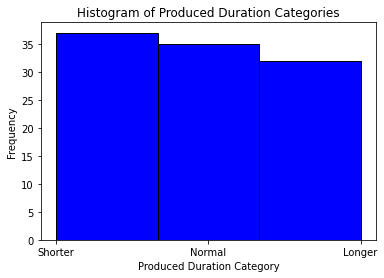

In [29]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(epochs.metadata["produced_duration_category"], bins=3, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Produced Duration Category')
plt.ylabel('Frequency')
plt.title('Histogram of Produced Duration Categories')

# Add axes values
plt.xticks([-1, 0, 1], ['Shorter', 'Normal', 'Longer'])

# Show plot
plt.show()

In [30]:
# Function that takes the epochs as input and outputs the np array corrsponding to the produced duration category
import numpy as np
def produced_duration_category(epochs):
    produced_duration = epochs.metadata["duration_produced"]

    # Choosing the number of standard deviations to define the categories
    n_std = 0.5
    
    shorter = produced_duration < (produced_duration.mean() - n_std * produced_duration.std())
    normal = (produced_duration >= (produced_duration.mean() - n_std * produced_duration.std())) & (produced_duration <= (produced_duration.mean() + n_std * produced_duration.std()))
    longer = produced_duration > (produced_duration.mean() + n_std * produced_duration.std())
    produced_duration_category = np.zeros(len(produced_duration))
    produced_duration_category[shorter] = -1
    produced_duration_category[normal] = 0
    produced_duration_category[longer] = 1
    return produced_duration_category

In [32]:
print(produced_duration_category(epochs))

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  0. -1.  0.  1.  0. -1.  1.  0.  0.
  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.
  0. -1. -1. -1. -1. -1.  0.  0. -1. -1. -1.  0.  1.  0.  1. -1.  0. -1.
 -1. -1.  0. -1. -1. -1. -1.  1.  1. -1.  0.  1.  0.  0.  1.  0. -1.  0.
 -1. -1. -1. -1.  1.  0.  1.  1.  0. -1. -1. -1.  1.  0. -1. -1. -1.  0.
  0.  0.  1. -1.  0.  0.  0. -1.  0. -1. -1. -1. -1. -1.]


Get power time courses from epochs

In [49]:
from mne.time_frequency import (
    tfr_array_morlet,
)

# Takes the epochs as input and returns the power time course within given frequencies as an array  number of epochs x number of channels x times
def get_power_epochs(epochs, power_freq_low_bound, power_freq_high_bound):
    frequencies = np.arange(power_freq_low_bound, power_freq_high_bound)  
    cycles_per_freq = 6
    
    power = tfr_array_morlet(epochs.get_data(), freqs=frequencies, n_cycles=cycles_per_freq, output="power", sfreq=config.resample_sfreq)
    power_timecourse = np.mean(power, axis=2)

    return mne.EpochsArray(power_timecourse, info=epochs.info)

C:\Users\gautier\AppData\Local\Temp/ipykernel_14468/1406565186.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  power = tfr_array_morlet(epochs.get_data(), freqs=frequencies, n_cycles=cycles_per_freq, output="power", sfreq=config.resample_sfreq)


Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


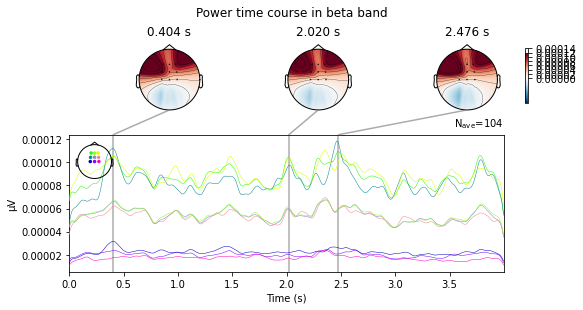

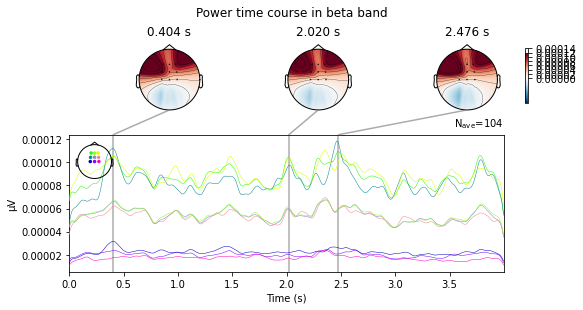

In [53]:
power_epochs = get_power_epochs(epochs, 14, 30)

# Display evoked power plot joint
power_epochs.average().plot_joint(title='Power time course in beta band')
